In [25]:
import torch

In [26]:
import torch


class GoGame:
    """
    Go game class.
    This class implements the Go game logic to be used for training the neural network.
    """

    def __init__(self, board_size=19) -> None:
        """
        Initializes the Go game with the given board size.
        Args:
            board_size (int): Size of the Go board (default is 19).
        """

        self.board_size = board_size
        self.board = torch.zeros((2, board_size, board_size), dtype=torch.float32)

    def place_stone(self, x, y, dim) -> None:
        """
        Places a stone of the specified color at the given position (x, y) on the board.
        Args:
            x (float): X-coordinate of the position.
            y (float): Y-coordinate of the position.
            dim (float): Color of the stone (0 for black, 1 for white).
        """
        self.board[dim][x][y] = 1

    def get_board(self) -> torch.Tensor:
        """
        Returns the current game board.
        Returns:
            torch.Tensor: Current game board.
        """
        return self.board

    def reset(self) -> None:
        """
        Resets the game board to the initial state.
        """
        self.board = torch.zeros(
            (2, self.board_size, self.board_size), dtype=torch.float32
        )

# dataset

In [27]:
import csv
import numpy as np
from torch.utils.data import Dataset
import time
import os


class GoDataset(Dataset):
    def __init__(self, path_of_data, length):
        """
        Initializes the GoDataset with the given CSV file path.
        Args:
            path (str): Path to the CSV file containing Go game data.
        """
        super().__init__()
        self.path = path_of_data
        self.preprocessed_path = "data/preprocessed data"
        self.length = length
        self.goGame = GoGame()
        self.char2idx = {c: i for i, c in enumerate("abcdefghijklmnopqrs")}
        self.dir_len = len(os.listdir("data/preprocessed data"))

        # Load data from CSV file
        with open(self.path, newline="") as csvfile:
            reader = csv.reader(csvfile, delimiter=",")
            # Read row by row
            self.data = list(reader)  # dtype: list[str]

    def __rotate_board(self, board, n):
        board = torch.rot90(board, k=n, dims=(2, 3))

        return board

    def __read_from_file(self, row):
        # get filename
        filename = os.path.join(
            self.preprocessed_path, f"subdir_{int(row[0][2:])%self.dir_len}", row[0]
        )
        boards = torch.load(filename + ".pt").to(dtype=torch.float32)

        random_start = np.random.randint(0, len(boards) - self.length)
        boards = boards[random_start : random_start + self.length]

        # get label
        self.goGame.reset()
        dim = 0 if row[random_start + self.length][0] == "B" else 1
        self.goGame.place_stone(
            self.char2idx[row[random_start + self.length][2]],
            self.char2idx[row[random_start + self.length][3]],
            dim,
        )
        label = self.goGame.get_board().clone()

        # add a board to the end of the sequence
        color_board = torch.zeros((2, 19, 19), dtype=torch.float32)
        color_board[dim] = torch.ones((19, 19), dtype=torch.float32)
        boards = torch.cat((boards, color_board.unsqueeze(0)), dim=0)

        # rotate boards and label
        boards = self.__rotate_board(boards, self.rotate_times)
        label = label.rot90(self.rotate_times, dims=(1, 2))
        label = label.reshape(-1)

        return boards, label

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get data at the given index.
        Args:
            idx (int): Index of the data sample.
        Returns:
            torch.Tensor: Processed and padded data sample.
        """
        # Get data at the given index
        row = self.data[idx]

        # Randomly rotate times
        self.rotate_times = np.random.randint(3)

        # Transform data into a board
        processed_data, label = self.__read_from_file(row)
        return processed_data, label

In [28]:
import torch
import torch.nn as nn


class ConvModule(nn.Module):
    """
    Conformer convolution module.

    Args:
        input_dim (int): input dimension.
        num_channels (int): number of depthwise convolution layer input channels.
        depthwise_kernel_size (int): kernel size of depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.0)
        bias (bool, optional): indicates whether to add bias term to each convolution layer. (Default: ``False``)
        use_group_norm (bool, optional): use GroupNorm rather than BatchNorm. (Default: ``False``)
    """

    def __init__(
        self,
        input_dim: int,
        num_channels: int,
        depthwise_kernel_size: int,
        dropout: float = 0.0,
        bias: bool = False,
        use_group_norm: bool = False,
    ) -> None:
        super().__init__()
        if (depthwise_kernel_size - 1) % 2 != 0:
            raise ValueError(
                "depthwise_kernel_size must be odd to achieve 'SAME' padding."
            )

        # Layer normalization for input
        self.layer_norm = nn.LayerNorm(input_dim)

        # Sequential layers: 1x1 Conv, GLU, Depthwise Conv, Normalization, Activation, 1x1 Conv, Dropout
        self.sequential = nn.Sequential(
            nn.Conv1d(
                input_dim,
                2 * num_channels,
                1,
                stride=1,
                padding=0,
                bias=bias,
            ),
            nn.GLU(dim=1),
            nn.Conv1d(
                num_channels,
                num_channels,
                depthwise_kernel_size,
                stride=1,
                padding=(depthwise_kernel_size - 1) // 2,
                groups=num_channels,
                bias=bias,
            ),
            nn.GroupNorm(num_groups=1, num_channels=num_channels)
            if use_group_norm
            else nn.BatchNorm1d(num_channels),
            nn.SiLU(),  # SiLU activation function (Sigmoid Linear Unit)
            nn.Conv1d(
                num_channels,
                input_dim,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=bias,
            ),
            nn.Dropout(dropout),
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the Conformer convolution module.

        Args:
            input (torch.Tensor): Input tensor with shape `(B, T, D)`.
            B: Batch size, T: Sequence length, D: Input dimension

        Returns:
            torch.Tensor: Output tensor with shape `(B, T, D)`.
        """
        x = self.layer_norm(input)
        # Transpose to shape `(B, D, T)` for 1D convolutions
        x = x.transpose(1, 2)
        x = self.sequential(x)  # Apply sequential layers
        return x.transpose(1, 2)  # Transpose back to shape `(B, T, D)`


class FeedForwardModule(nn.Module):
    """
    Feedforward module with Layer Normalization, Linear layers, SiLU activation, and Dropout.

    Args:
        input_dim (int): Input dimension.
        hidden_dim (int): Hidden layer dimension.
        dropout (float, optional): Dropout probability. (Default: 0.1)
    """

    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super(FeedForwardModule, self).__init__()
        self.module = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # SiLU activation function (Sigmoid Linear Unit)
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        Forward pass of the FeedForwardModule.

        Args:
            x (torch.Tensor): Input tensor with shape `(B, T, D)`.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input tensor.
        """
        return self.module(x)


class ConformerBlock(nn.Module):
    """
    Conformer layer that constitutes Conformer.

    Args:
        input_dim (int): input dimension.
        ffn_dim (int): hidden layer dimension of the feedforward network.
        num_attention_heads (int): number of attention heads.
        depthwise_conv_kernel_size (int): kernel size of the depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.1)
        use_group_norm (bool, optional): use ``GroupNorm`` rather than ``BatchNorm1d``
            in the convolution module. (Default: ``False``)
        convolution_first (bool, optional): apply the convolution module ahead of
            the attention module. (Default: ``False``)
    """

    def __init__(
        self,
        input_dim,
        ffn_dim,
        num_attention_heads,
        depthwise_conv_kernel_size,
        dropout=0.1,
        use_group_norm=False,
        convolution_first=False,
    ):
        super().__init__()
        self.ffn1 = FeedForwardModule(input_dim, ffn_dim, dropout)
        self.ffn2 = FeedForwardModule(input_dim, ffn_dim, dropout)
        self.conv = ConvModule(
            input_dim,
            input_dim,
            depthwise_conv_kernel_size,
            dropout,
            use_group_norm=use_group_norm,
        )
        self.self_attn = nn.MultiheadAttention(
            input_dim, num_attention_heads, dropout=dropout
        )
        self.self_attn_dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(input_dim)
        self.convolution_first = convolution_first

    def __apply_conv(self, x):
        """
        Apply the convolution module.

        Args:
            x (torch.Tensor): Input tensor with shape `(T, B, D)`.

        Returns:
            torch.Tensor: Output tensor after applying the convolution module.
        """
        residual = x
        # Transpose to shape `(B, T, D)` for 1D convolutions
        x = x.transpose(0, 1)
        x = self.conv(x)
        x = x.transpose(0, 1)  # Transpose back to shape `(T, B, D)`
        x = x + residual
        return x

    def forward(self, x):
        """
        Forward pass of the ConformerBlock.

        Args:
            x (torch.Tensor): Input tensor with shape `(T, B, D)`.

        Returns:
            torch.Tensor: Output tensor with the same shape as the input tensor.
        """
        residual = x
        x = self.ffn1(x)  # First feedforward module
        x = 0.5 * x + residual  # Residual connection and scaling

        if self.convolution_first:
            x = self.__apply_conv(x)  # Apply convolution module if specified

        residual = x
        x = self.layer_norm(x)  # Layer normalization
        x, _ = self.self_attn(x, x, x)  # Multihead self-attention
        x = self.self_attn_dropout(x)
        x = x + residual  # Residual connection

        if not self.convolution_first:
            x = self.__apply_conv(x)  # Apply convolution module if specified

        residual = x
        x = self.ffn2(x)  # Second feedforward module
        x = 0.5 * x + residual  # Residual connection and scaling
        x = self.layer_norm(x)  # Final layer normalization
        return x


class Conformer(nn.Module):
    """
    Args:
        input_dim (int): input dimension.
        num_heads (int): number of attention heads in each Conformer layer.
        ffn_dim (int): hidden layer dimension of feedforward networks.
        num_layers (int): number of Conformer layers to instantiate.
        depthwise_conv_kernel_size (int): kernel size of each Conformer layer's depthwise convolution layer.
        dropout (float, optional): dropout probability. (Default: 0.1)
        use_group_norm (bool, optional): use ``GroupNorm`` rather than ``BatchNorm1d``
            in the convolution module. (Default: ``False``)
        convolution_first (bool, optional): apply the convolution module ahead of
            the attention module. (Default: ``False``)
    """

    def __init__(
        self,
        input_dim,
        num_heads,
        ffn_dim,
        num_layers,
        depthwise_conv_kernel_size,
        dropout=0.1,
        use_group_norm=False,
        convolution_first=False,
    ):
        super().__init__()

        # Instantiate Conformer blocks
        self.conformer_blocks = nn.ModuleList(
            [
                ConformerBlock(
                    input_dim,
                    ffn_dim,
                    num_heads,
                    depthwise_conv_kernel_size,
                    dropout,
                    use_group_norm,
                    convolution_first,
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x: torch.Tensor):
        """
        Forward pass of the Generator (Conformer model).

        Args:
            x (torch.Tensor): input with shape `(B, T, input_dim)`.

        Returns:
            torch.Tensor: output with shape `(B, T, input_dim)`.
        """
        batch_size, seq_length, _, _, _ = x.shape
        x = x.view(batch_size, seq_length, -1)  # Flatten input tensor

        x = x.transpose(0, 1)  # Transpose to shape `(T, B, input_dim)`

        # Pass input through Conformer blocks
        for layer in self.conformer_blocks:
            x = layer(x)

        x = x.transpose(0, 1)  # Transpose back to shape `(B, T, input_dim)`

        return x

import torch
import torch.nn as nn


class Generator(nn.Module):
    """
    Generator model using Conformer architecture.

    Args:
        input_dim (int): Input dimension.
        num_heads (int): Number of attention heads in each Conformer layer.
        ffn_dim (int): Hidden layer dimension of feedforward networks in Conformer layers.
        num_layers (int): Number of Conformer layers.
        depthwise_conv_kernel_size (int): Kernel size of depthwise convolution in Conformer layers.
        dropout (float, optional): Dropout probability. (Default: 0.1)
        use_group_norm (bool, optional): Use GroupNorm instead of BatchNorm1d in Conformer layers. (Default: False)
        convolution_first (bool, optional): Apply convolution module ahead of attention module. (Default: False)
    """

    def __init__(
        self,
        input_dim,
        num_heads,
        ffn_dim,
        num_layers,
        depthwise_conv_kernel_size,
        dropout=0.1,
        use_group_norm=False,
        convolution_first=False,
    ):
        super(Generator, self).__init__()

        # Instantiate the Conformer module
        self.conformer = Conformer(
            input_dim,
            num_heads,
            ffn_dim,
            num_layers,
            depthwise_conv_kernel_size,
            dropout,
            use_group_norm,
            convolution_first,
        )

        # Output layer: Linear + Softmax
        self.output_layer = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            # TODO: try different activation functions
            nn.Softmax(dim=-1),
        )

    def forward(self, x: torch.Tensor):
        """
        Forward pass of the Generator (Conformer model).

        Args:
            x (torch.Tensor): Input tensor with shape `(B, T, input_dim)`.

        Returns:
            torch.Tensor: Output tensor with shape `(B, output_dim)`.
        """
        # Pass the input through the Conformer layers
        conformer_output = self.conformer(x)

        # truncate the output to the last time step
        output = conformer_output[:, -1, :]

        # Pass the output through the linear layer
        output = self.output_layer(output)

        return output, x  # Return the original input tensor without cloning


In [29]:
goDataset = GoDataset("data/train/dan_train.csv", 32)

In [30]:
from torch.utils.data import DataLoader

G_path='data/models/gen/0_epoch310.pth'


config = {
    "input_dim": 2 * 19 * 19,
    "num_heads": 2,
    "ffn_dim": 512,
    "num_layers": 4,
    "depthwise_conv_kernel_size": 7,
    "dropout": 0.1,
    "use_group_norm": False,
    "convolution_first": False,
    "lr": 0.0001,
    "gen_path": "data/models/gen",
    "dis_path": "data/models/dis",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "batch_size": 32,
    "clip_value": 1,
    "data_len": 32,
    "epochs": 200,
    "early_stop": 200,
    "selected": 0
}

goDataset = GoDataset("data/train/dan_train.csv", config["data_len"])
val_loader = DataLoader(
    goDataset, batch_size=int(config["batch_size"]), shuffle=False, pin_memory=True
)

# plot

Evaluating generator:


  0%|          | 0/3130 [00:00<?, ?it/s]


TypeError: Invalid shape (2, 19, 19) for image data

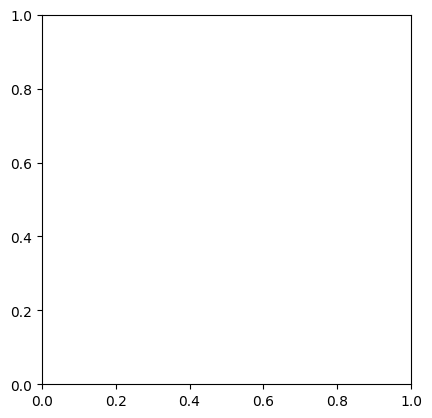

In [37]:
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from IPython.display import clear_output

def plot_board(board):
    board = board.reshape(2, 19, 19)
    plt.imshow(board)
    plt.show()

def plot_boards(boards):
    for board in boards:
        plot_board(board)
        time.sleep(5)
        clear_output(wait=True)


model = torch.load(G_path).to("cpu")

def evaluate_G(model, val_loader):
    print(f"Evaluating generator:")

    # Set the generator and discriminator in evaluation mode
    model.eval()

    # Iterate through the validation loader
    for i, (x, y) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
            # Generate fake data and conditioning information from the generator
            output, _ = model(x)

        plot_boards(output)

        plot_boards(y)


evaluate_G(model, val_loader)